# Data Visualization
What is still needed:
* EER, NER, WER data
* 

In [1]:
import os
import io
import zipfile
import requests

import numpy as np
import scipy as sp
import pandas as pd

from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline

pd.set_option('display.max_columns', 500)
plt.rcParams['figure.figsize'] = 12, 8

In [2]:
def makeCorrPlots(x, y, df, log=False):
    """Takes two variables as inputs, fits a univariate linear regression model,
    and outputs the scatter plot, linear fit and correlation coefficient"""
    
    # drop nans
    try:
        tmp = df[[x,y]]
        tmp = tmp.dropna()
        X, Y = tmp[x].astype(float), tmp[y].astype(float)
    except:
        print(x, y)
        return
    
    if not len(X) or not len(Y):
        return
    
    if log:
        X[X == 0] = 1e-12;
        X = np.log10(X)
    
    # fit univariate regression
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(X, Y)
    
    # plot2
    plt.scatter(X, Y, color='b', alpha=0.5)
    plt.plot(X, intercept + slope*X, color='firebrick')
    plt.title('{} v. {}{} (corr= {:.2f})'.format(y, 'log ' if log else '', x, np.corrcoef(X, Y)[0][1]))
    
def clean(df, col='eui', use_log=True, nonneg=False, nstd=2, onesided=None, bounds=None):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    onesided = nonneg if onesided is None else onesided
    try:
        if bounds:
            xmin, xmax = bounds
            if xmin is not None:
                df = df[df[col] >= xmin]
            if xmax is not None:
                df = df[df[col] <= xmax]
        if nonneg:
            df = df[df[col] >= 0]
        if use_log:
            df = df[df[col] != 0]
            vals = np.log10(df[col].astype(float))
        else:
            vals = df[col].astype(float)
    except ValueError:
        return df
    
    if nstd:
        vals_centered = vals - np.mean(vals)
        if not onesided:
            vals_centered = np.abs(vals_centered)
        return df[ vals_centered < nstd*np.std(vals) ]
    return df

In [3]:
borough_map = {
    'MN': 'Manhattan',
    'BK': 'Brooklyn',
    'BX': 'Bronx',
    'QN': 'Queens',
    'SI': 'Staten Island'
}

## The Data

In [4]:
df = pd.read_csv('final_df.csv').drop('Unnamed: 0', axis=1)

# Make borough names pretty
# df.Borough = df.Borough.map(borough_map)

df.head()

,BBL,Longitude,Latitude,age,BldgArea,UnitsTotal,EER_km,WER_km,NER_km,EUI_2016_x,Group_mean_EUI_2016,Group_mean_water_intensity,Group_mean_naturalgas_intensity,Pred_EUI_lr,EER_lr,Pred_WUI_lr,WER_lr,Pred_NUI_lr,NER_lr,EUI_2016_y,avgEER,avgWER,avgNER
0,1011860091,-73.982338,40.784528,107,58266,25,0.806386,0.391934,0.023531,68.3,84.698877,67.485929,49.170764,117.992099,0.578852,51.465065,0.513941,37.434380,0.030909,68.3,0.692619,0.452937,0.027220
1,1000167501,-74.017891,40.709851,32,179174,239,0.899658,0.770679,0.961626,76.2,84.698877,67.485929,49.170764,137.652969,0.553566,54.824231,0.948668,49.059700,0.963803,76.2,0.726612,0.859674,0.962715
2,1000167502,-74.017570,40.710107,31,123284,133,0.876045,0.660879,0.314495,74.2,84.698877,67.485929,49.170764,131.014743,0.566348,46.049040,0.968533,46.818962,0.330293,74.2,0.721197,0.814706,0.322394
3,1000167504,-74.016859,40.709915,31,72913,110,0.846528,0.581158,0.973950,71.7,84.698877,67.485929,49.170764,138.567204,0.517438,51.552684,0.760775,47.832432,1.001201,71.7,0.681983,0.670967,0.987576
4,1000167505,-74.018060,40.709077,30,203837,247,1.200724,0.835730,1.327636,101.7,84.698877,67.485929,49.170764,133.538364,0.761579,51.481771,1.095533,48.612780,1.342875,101.7,0.981152,0.965632,1.335256


In [6]:
df = pd.read_csv('merged-w-latlon.csv')#.drop('Unnamed: 0', axis=1)

# Make borough names pretty
df.Borough = df.Borough.map(borough_map)

df.head()

,BBL,EUI_2013,floorArea_2013,EUI_2014,floorArea_2014,EUI_2015,floorArea_2015,EUI_2016,floorArea_2016,Occupancy,TYPE_2016,water_intensity,naturalgas_use,Metered Areas (Energy),Metered Areas (Water),naturalgas_intensity,Borough,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,YearBuilt,XCoord,YCoord,ZipCode,Address,Longitude,Latitude
0,1011860091,60.9,63121.0,70.9,58266.0,68.6,58266.0,68.3,58266.0,100.0,Multifamily Housing,26.45,67417.0,Whole Building,Whole Building,1.157056,Manhattan,6641,58266,0,58266,0,0,12.0,25,25,1910,989141.0,225102.0,10024.0,316 WEST 79 STREET,-73.982338,40.784528
1,1000167501,64.9,199141.0,74.2,220821.0,77.0,220821.0,76.2,220821.0,100.0,Multifamily Housing,52.01,10441275.8,Whole Building,Whole Building,47.283890,Manhattan,16951,179174,1092,177488,0,1092,25.0,238,239,1985,979290.0,197895.0,10280.0,377 RECTOR PLACE,-74.017891,40.709851
2,1000167502,71.5,150667.0,74.8,150855.0,41.1,150855.0,74.2,150855.0,100.0,Multifamily Housing,44.60,2332818.2,Whole Building,Whole Building,15.463977,Manhattan,27838,123284,11136,112148,0,0,15.0,133,133,1986,979379.0,197988.0,10280.0,350 ALBANY STREET,-74.017570,40.710107
3,1000167504,74.6,112312.0,77.7,91774.0,73.3,91774.0,71.7,91774.0,100.0,Multifamily Housing,39.22,4395045.3,Whole Building,Not Available,47.889874,Manhattan,16108,72913,4295,68618,0,4295,9.0,107,110,1986,979576.0,197918.0,10280.0,300 ALBANY STREET,-74.016859,40.709915
4,1000167505,116.7,235366.0,106.2,257092.0,106.7,257092.0,101.7,257092.0,100.0,Multifamily Housing,56.40,16783196.3,Whole Building,Not Available,65.280897,Manhattan,23910,203837,1177,202660,1177,0,26.0,246,247,1987,979243.0,197613.0,10280.0,380 RECTOR PLACE,-74.018060,40.709077


In [ ]:
PLUTO_cache = 'data/pluto16.csv'
PLUTO_url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip'

if not os.path.isfile(PLUTO_cache):
    # Make sure directory exists
    if not os.path.isdir('data'):
        os.makedirs('data')
    
    with zipfile.ZipFile(io.BytesIO(requests.get(PLUTO_url).content)) as z:
        # Join all csv files in the archive
        df_pluto = pd.concat([
            pd.read_csv(z.open(f))
            for f in z.namelist()
            if os.path.splitext(f)[1] == '.csv'
        ])
    
    # Save cache
    df_pluto.to_csv(PLUTO_cache, index=False)

df_pluto = pd.read_csv(PLUTO_cache)


df_pluto.Borough = df_pluto.Borough.map(borough_map)

df_pluto.head()

## Distribution of our Output Variables

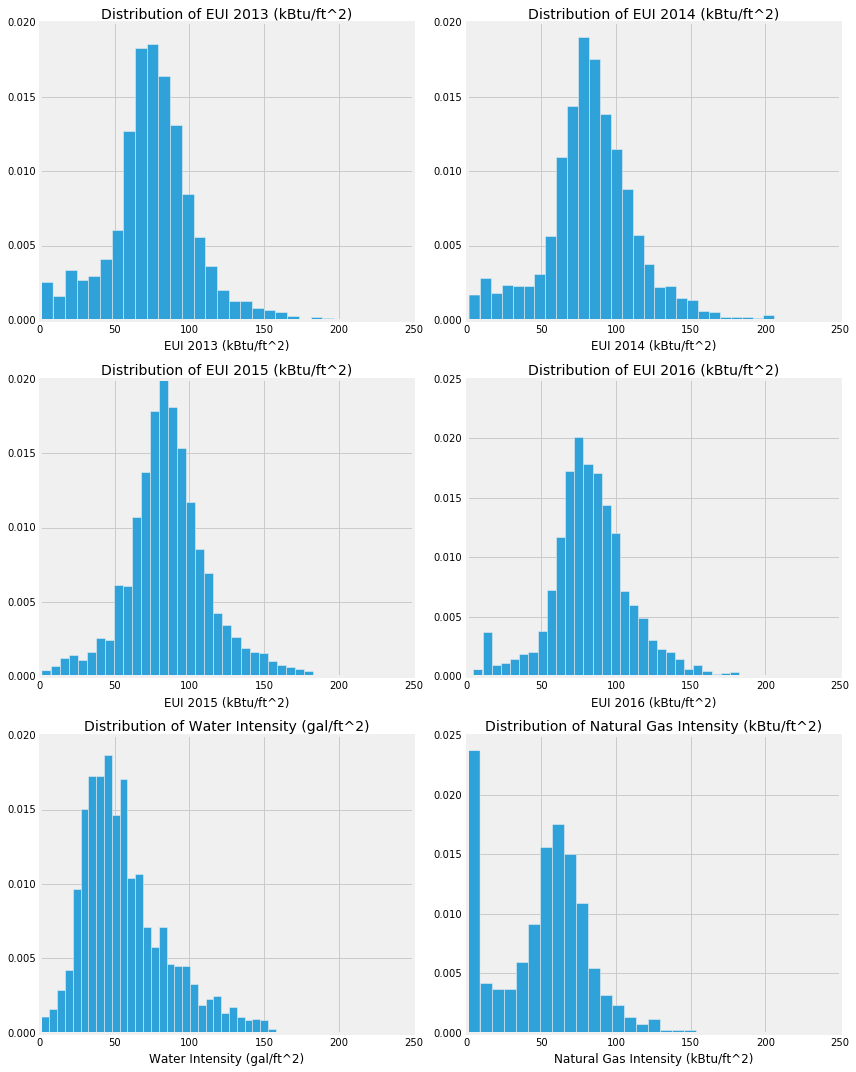

In [7]:
plt.figure(figsize=(12, 15))

columns = ['EUI_2013', 'EUI_2014', 'EUI_2015', 'EUI_2016', 'water_intensity', 'naturalgas_intensity']
names = ['EUI 2013 (kBtu/ft^2)', 'EUI 2014 (kBtu/ft^2)', 'EUI 2015 (kBtu/ft^2)', 'EUI 2016 (kBtu/ft^2)', 'Water Intensity (gal/ft^2)', 'Natural Gas Intensity (kBtu/ft^2)']#columns # give prettier names [..., 'Natural Gas Intensity (kBtu/ft^2)]

for i, (name, col) in enumerate(zip(names, columns), 1):
    plt.subplot(3,2,i)
    plt.hist(clean(df, col, nonneg=True, bounds=(1, 400))[col], bins=30, normed=True) # Clean gets rid of outliers
    plt.title('Distribution of {}'.format(name.replace('_', ' ')), fontsize=14)
    plt.xlabel(name) # should add units
    plt.xlim([0, 250])
plt.tight_layout()

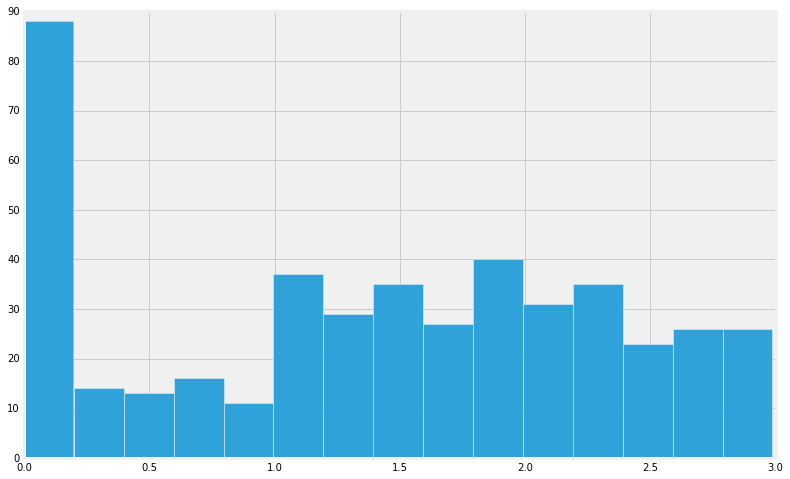

In [25]:
df[df['naturalgas_intensity'] < 3]['naturalgas_intensity'].hist(bins=15)

In [22]:
df[df['naturalgas_intensity'] < 1]['naturalgas_intensity'].mode()

0    0.100298
dtype: float64

## Total Number of Buildings in each borough

In [ ]:
prop

In [ ]:
plt.figure(figsize=(8, 5))

# Get counts
prop = df.groupby('Borough').count()['ZipCode'].sort_values()
xprop = np.arange(len(prop))

plt.barh(xprop, prop.values, color=[np.array([41, 144, 210]) / 255.])
plt.title('Total In-Scope Buildings by Borough', fontsize=18)
plt.xlabel('Number of Buildings')
plt.yticks(xprop + 0.4, prop.index);

## Percent of Total Buildings for each borough represented in this dataset
Same as above but divided by the total number of buildings in PLUTO for that borough.

In [ ]:
# Get percentages
prop = (df.groupby('Borough').count()['ZipCode'] / df_pluto.groupby('Borough').count()['ZipCode']).sort_values()
xprop = np.arange(len(prop))

plt.barh(xprop, prop.values * 100.)
plt.title('Percent In-Scope Buildings by Borough')
plt.xlabel('Percent of Total Buildings Reporting (%)')
plt.yticks(xprop + 0.4, prop.index);

## Relationship between EER, NER, and WER
EER, NER, WER two at a time to see if the pattern moves together

In [ ]:
for i, (x, y) in enumerate([('EER', 'NER'), ('EER', 'WER'), ('WER', 'NER')], 1):
    plt.subplot(1, 3, i)
    makeCorrPlots(x, y, df, log=True)
    plt.xlabel(x)
    plt.ylabel(y)

## Log histogram of each EER, NER, WER for multifamily

In [ ]:
for i, col in enumerate(['EER', 'NER', 'WER'], 1):
    plt.subplot(1, 3, i)
    plt.hist(col)

## Plot EUI of individual clusters?
Not sure if we need this or if it'd be interesting

In [ ]:
n_groups = len(df['km_group'].unique())
for i, group in enumerate(df.groupby('km_group'), 1):
    plt.subplot(n_groups/2, 2, i)
    group.hist('EUI_2016')

## Clustering Silhouette Scores

In [ ]:
# The features to use
features = [ ... ]
U = df[features]

# The range of clusters to try
x_sil = np.arange(2, 11)

# Compute silhouette scores
sil_scores = [
    silhouette_score(U, KMeans(i).fit(U).labels_)
    for i in x_sil
]

print('The best silhouette score is at: {} clusters'.format(x_sil[np.argmax(sil_scores)]))
plt.figure(figsize=(15,6))
plt.plot(x_sil, sil_scores)
plt.title('KMeans Evaluation: Silhouette Score')
plt.xlabel('N Clusters')
plt.ylabel('Silhouette Score');

## Lasso Regularization Validation

In [ ]:
# Create 10 random training-validation splits
splits = [
    train_test_split(df[features], df['EUI_2016'], train_size=0.7)
    for _ in range(10)
]

# Pick lambdas for validation
lambdas = np.linspace(10, 1000, 100)

# Compute R^2 for each model and each split
split_scores = [
    [
        Lasso(alpha=lam).fit(X_tr, y_tr).score(X_val, y_val)
        for lam in lambdas
    ]
    for X_tr, X_val, y_tr, y_val in splits
]

# Plot scores for all splits
for i, models in enumerate(split_scores, 1):
    # Plot score for each model
    for label, scores in models.items():
        plt.plot(lambdas, scores, label='Split {}'.format(i))
plt.title('Cross Validation of Lasso Regression Regularization Value')
plt.xlabel('Lambda Value')
plt.ylabel('R Squared')
plt.legend()

## Anything else?